In [ ]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 MB 12.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.7.0.72
    Uninstalling opencv-contrib-python-4.7.0.72:
      Successfully uninstalled opencv-contrib-python-4.7.0.72


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 86.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=9779fa70b43a113af08c1c786f78f986f5555448fe2274e91ec8b4776e39f875
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=0d66f2e5b89b1b549740a81c7a860dc023a94b8b0bd2f317ed956322ef2d0a7e
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#PyTocrch Implementation
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)


torch.cuda.is_available()

False

In [ ]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])


    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')

        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

    def __len__(self):
        return self.len

In [ ]:
X = sorted(glob.glob('/content/Water Bodies Dataset - Copy/Images/*'))
y = sorted(glob.glob('/content/Water Bodies Dataset - Copy/Masks/*'))

In [ ]:
len(y)

2841

#Seperate the data into train and split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob

from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

In [ ]:
def prep_image(image, crop_size, size_y, size_x):
    # Resize the image
    prepd_image = cv2.resize(image,(size_y, size_x))
    # Crop the image to remove the border black pixels
    prepd_image = prepd_image[crop_size:-crop_size, crop_size:-crop_size]
    return prepd_image

In [ ]:
size_x=148
size_y=148
crop_size=10

In [2]:
!unzip '/content/drive/MyDrive/Water-Bodies-Dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Water Bodies Dataset - Copy/Images/water_body_1809.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1810.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1811.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1812.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1813.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1814.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1815.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1816.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1817.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1818.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1819.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_182.jpg  
  inflating: Water Bodies Dataset - Copy/Images/water_body_1820.jpg  
  inflating: Water Bodies Dataset - Copy

In [ ]:
################# Storing Train Images into an array #############
train_images=[]

for directory_path in glob.glob("/content/Water Bodies Dataset - Copy/Images"):
    for img_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        #print(img_path)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=prep_image(img,crop_size,size_y,size_x)
        train_images.append(img)

train_images = np.array(train_images) #converting list to array

In [ ]:
################# Storing Train Masks into an array #############
train_masks = []

for directory_path in glob.glob("/content/Water Bodies Dataset - Copy/Masks"):
    for mask_path in glob.glob(os.path.join(directory_path,"*.jpg")):
        mask=cv2.imread(mask_path,0)
        mask=prep_image(mask,crop_size,size_y,size_x)
        train_masks.append(mask)

train_masks = np.array(train_masks) #converting list to array

In [ ]:
len(train_images), len(train_masks)

(2841, 2841)

In [ ]:
train_images[0].shape, train_masks[0].shape

((128, 128, 3), (128, 128))

In [ ]:
np.min(train_images[0]), np.max(train_images[0]), np.min(train_masks[0]), np.max(train_masks[0])

(0, 185, 0, 255)

In [ ]:
#normalizing
x = train_images/255
y = train_masks/255

In [ ]:
np.min(x[0]), np.max(x[0]), np.min(y[0]), np.max(y[0])

(0.0, 0.7254901960784313, 0.0, 1.0)

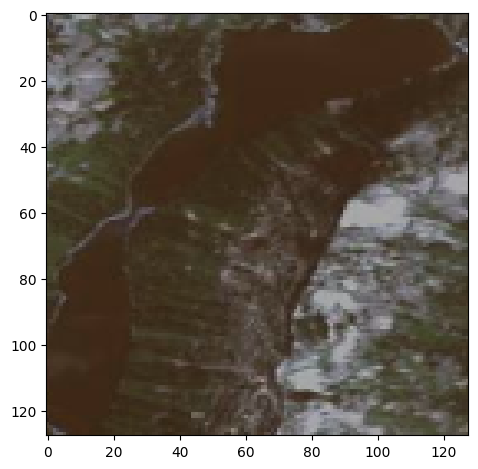

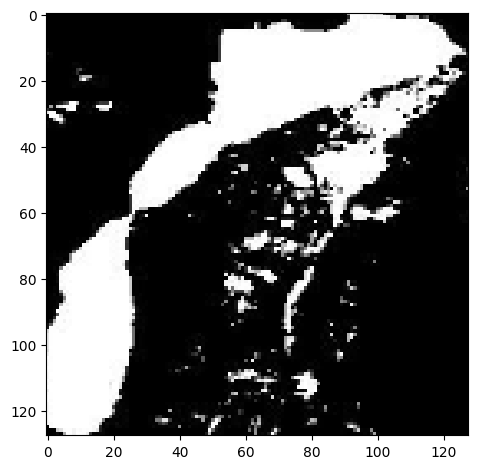

0.06666666666666667 0.6941176470588235
(128, 128, 3)
0.0 1.0
(128, 128)


In [ ]:
########## Displaying random image from X_train and Y_train #########
random_num = random.randint(0,516)
imshow(x[random_num])
plt.show()
imshow(y[random_num])
plt.show()

test_img = x[random_num]
test_img2 = y[random_num]
print(test_img.min(), test_img.max())
print(test_img.shape)

print(test_img2.min(), test_img2.max())
print(test_img2.shape)

In [ ]:
#splitting
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
#UNet model building
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    return model

In [ ]:
def get_model():
    return simple_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [ ]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(x_train,
          y_train,
          batch_size=25,
          epochs=10,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/10
91/91 [==============================] - 297s 3s/step - loss: 0.3151 - accuracy: 0.7581 - val_loss: 0.2947 - val_accuracy: 0.7680
Epoch 2/10
91/91 [==============================] - 301s 3s/step - loss: 0.3136 - accuracy: 0.7594 - val_loss: 0.2981 - val_accuracy: 0.7657
Epoch 3/10
91/91 [==============================] - 296s 3s/step - loss: 0.3125 - accuracy: 0.7589 - val_loss: 0.2903 - val_accuracy: 0.7743
Epoch 4/10
91/91 [==============================] - 295s 3s/step - loss: 0.2938 - accuracy: 0.7658 - val_loss: 0.2897 - val_accuracy: 0.7735
Epoch 5/10
91/91 [==============================] - 302s 3s/step - loss: 0.2901 - accuracy: 0.7681 - val_loss: 0.2991 - val_accuracy: 0.7668
Epoch 6/10
91/91 [==============================] - 300s 3s/step - loss: 0.3004 - accuracy: 0.7628 - val_loss: 0.3210 - val_accuracy: 0.7611
Epoch 7/10
91/91 [==============================] - 299s 3s/step - loss: 0.2790 - accuracy: 0.7716 - val_loss: 0.2705 - val_accuracy: 0.7791
Epoch 8/10
91

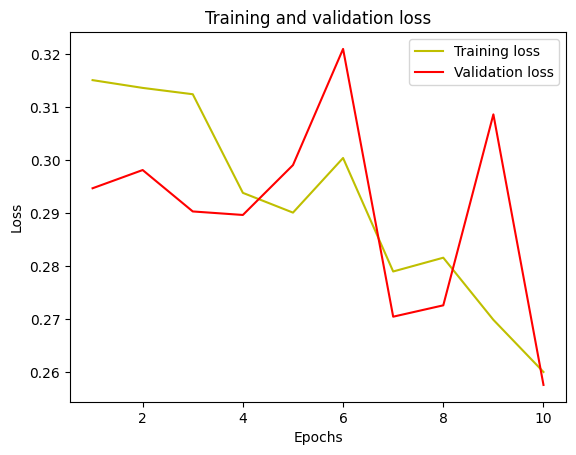

In [ ]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

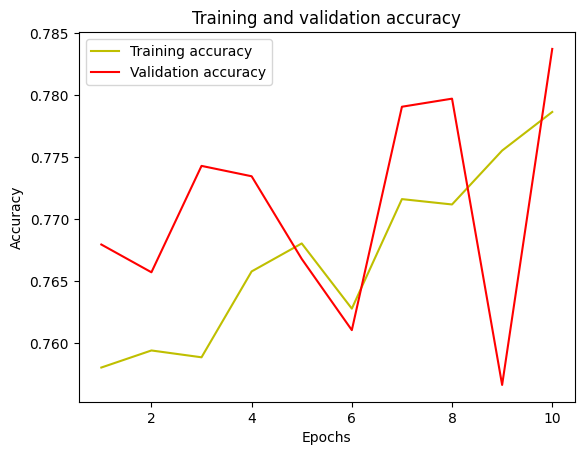

In [ ]:
#plot the training and validation accuracy at each epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Original Image: 


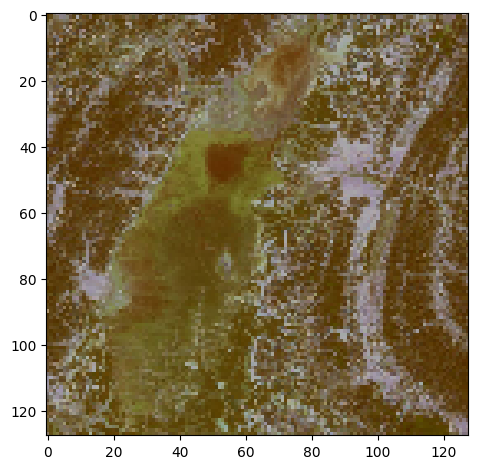

1/1 [==============================] - 0s 253ms/step
Predicted Mask: 


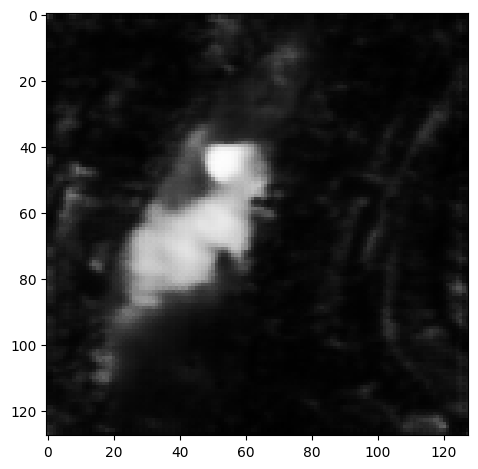

Original Image: 


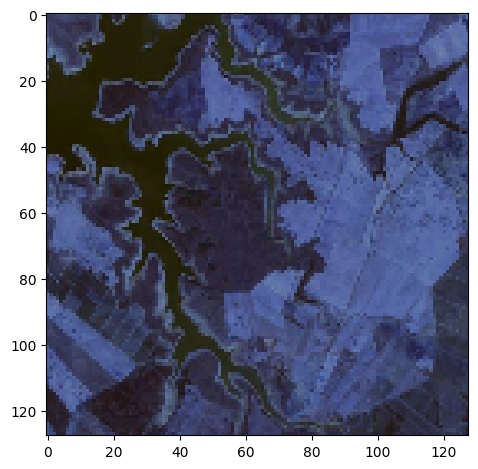

1/1 [==============================] - 0s 58ms/step
Predicted Mask: 


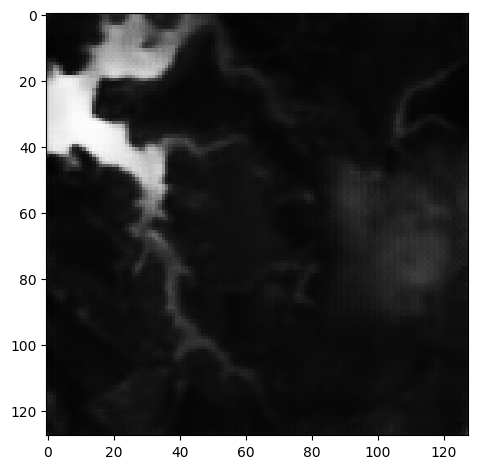

Original Image: 


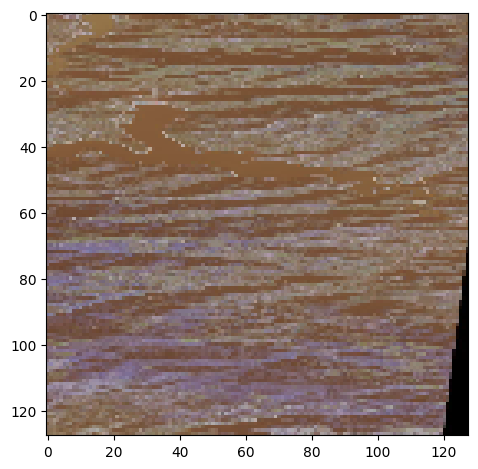

1/1 [==============================] - 0s 41ms/step
Predicted Mask: 


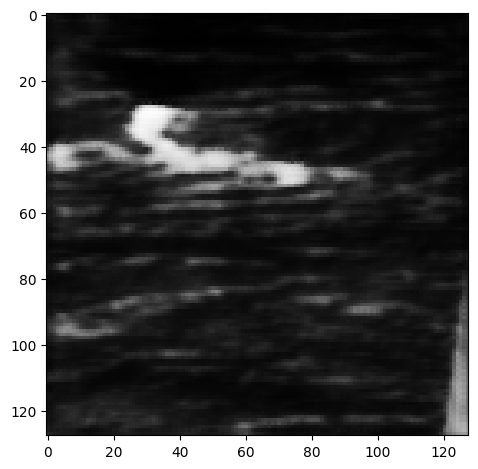

Original Image: 


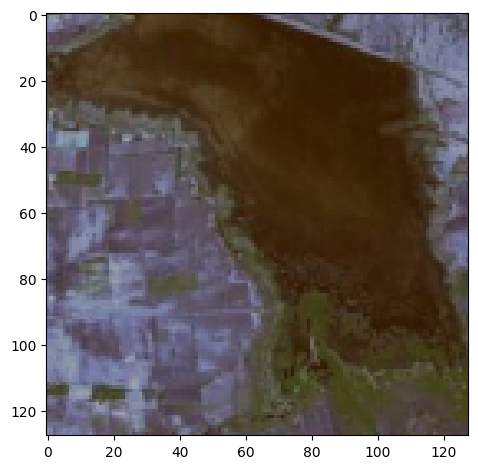

1/1 [==============================] - 0s 42ms/step
Predicted Mask: 


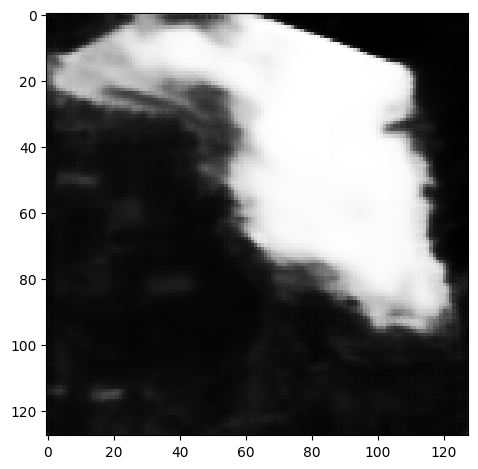

Original Image: 


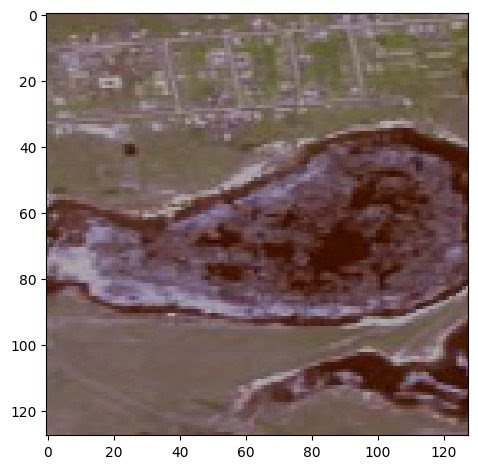

1/1 [==============================] - 0s 43ms/step
Predicted Mask: 


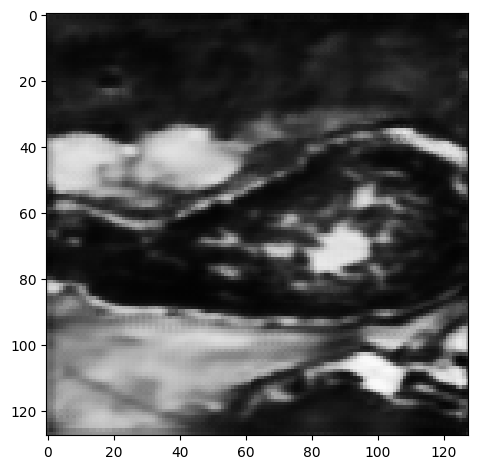

Original Image: 


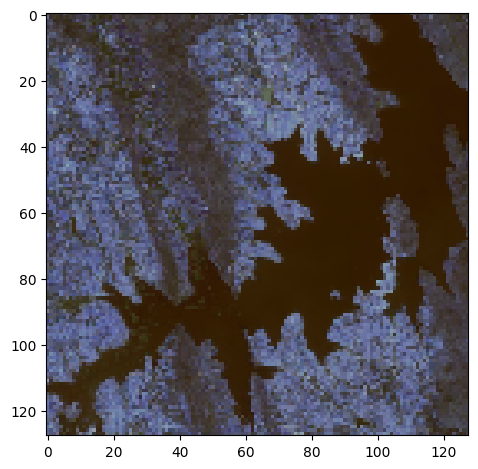

1/1 [==============================] - 0s 48ms/step
Predicted Mask: 


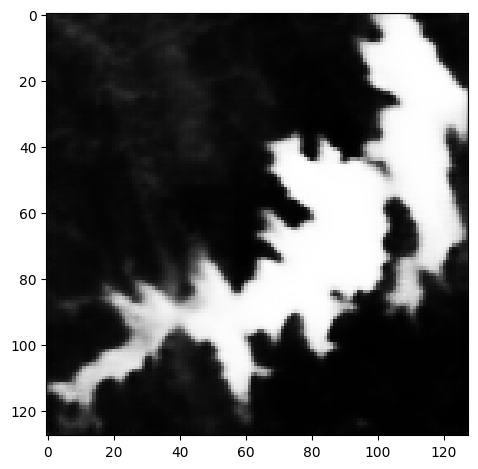

Original Image: 


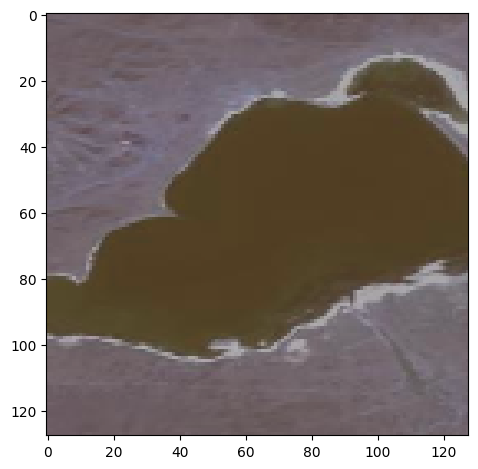

1/1 [==============================] - 0s 50ms/step
Predicted Mask: 


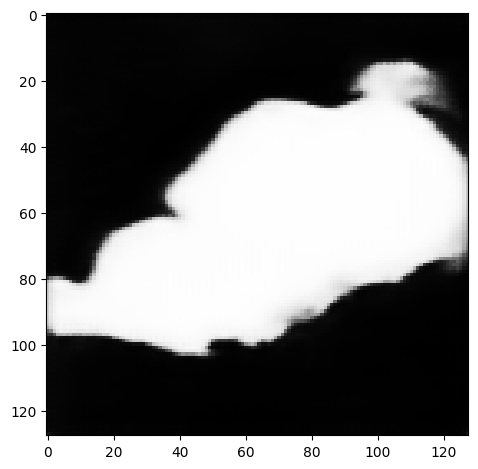

In [ ]:
########## Predicting random images from x_val #########
for i in range(0,7):
    random_num = random.randint(0,500)
    original_image = x_val[random_num]
    imshow(original_image)
    print("Original Image: ")
    plt.show()

    original_image=np.expand_dims(original_image,axis=0)
    predicted_mask = model.predict(original_image)
    predicted_mask = predicted_mask.reshape(mask.shape)
    print("Predicted Mask: ")
    imshow(predicted_mask,cmap='gray')
    plt.show()
    i+=1

In [ ]:
model.save("water_bodies_segmentation_76.h5")